In [1]:
import torch
from torch.utils import data
from torchvision import transforms
from os import listdir
from skimage.io import imread
import matplotlib.pyplot as plt
from random import sample 
from numpy.random import poisson, normal, beta
import time
from copy import deepcopy, copy
from PIL import Image
import numpy as np

In [2]:
"""
 This is a function that takes in an image, and a dispersion parameter
 p and n define the size of the mean pixel patch and the number of patches
 replaces pixel with random noise in randomly selected patches of the image
"""

def patchnoiser(image, theta, p , n):
    x, y, c = image.shape
    means = torch.sum(image, dim=(0,1))/x/y
    
    for i in range(n):
        px = min(poisson(lam = p, size=None),x)
        py = min(poisson(lam = p, size=None),y)
        
        max_x = x + 1 - px
        max_y = y + 1 - py
        
        x_range = list(range(max_x))
        y_range = list(range(max_y))
        
        patch1_x = sample(x_range,1)[0]
        patch1_y = sample(y_range,1)[0]
        
        def pixeltonoise(x):
            if(x<10 **(-6)):
                return x
            if(x > 1 - 10**(-6)):
                return x

            a = (1 - theta)/theta * x
            b = (1 - theta)/theta * (1 - x)

            return(beta(a, b))
    
        pixeltonoise = np.vectorize(pixeltonoise)
        
        noise0 = pixeltonoise(float(means[0]) * np.ones(shape = (px, py)) )
        noise1 = pixeltonoise(float(means[1]) * np.ones(shape = (px, py)) )
        noise2 = pixeltonoise(float(means[2]) * np.ones(shape = (px, py)) )
        
        noise0 = torch.from_numpy(noise0)
        noise1 = torch.from_numpy(noise1)
        noise2 = torch.from_numpy(noise2)
        
        image[patch1_x:(patch1_x+px), patch1_y:(patch1_y+py),0] = noise0
        image[patch1_x:(patch1_x+px), patch1_y:(patch1_y+py),1] = noise1
        image[patch1_x:(patch1_x+px), patch1_y:(patch1_y+py),2] = noise2
    
    return(image)

"""
 This is a function that takes in an image, and a dispersion parameter
 replaces each pixel with a noisy version of that pixel 
"""

def uniformnoiser(image, theta):
    x, y, c = image.shape
    
    def pixeltonoise(x):
        if(x<10 **(-6)):
            return x
        if(x > 1 - 10**(-6)):
            return x
        
        a = (1 - theta)/theta * x
        b = (1 - theta)/theta * (1 - x)
        
        return(beta(a, b))
    
    pixeltonoise = np.vectorize(pixeltonoise)
    
    image = np.asarray(image)
    image = pixeltonoise(image)
    image = torch.from_numpy(image)
    
    return(image)

"""
 This is a function that takes in an image, and a dispersion parameter
 p and n define the size of the mean pixel patch and the number of patches
 replaces pixel with random noise in randomly selected patches of the image
"""

def patchswap(image, p, n):
    x, y, c = image.shape
    
    for i in range(n):
        px = min(poisson(lam = p, size=None),x)
        py = min(poisson(lam = p, size=None),y)
        
        max_x = x + 1 - px
        max_y = y + 1 - py
        
        x_range = list(range(max_x))
        y_range = list(range(max_y))
        
        patch1_x = sample(x_range,1)[0]
        patch1_y = sample(y_range,1)[0]
        patch1 = deepcopy(image[patch1_x:(patch1_x + px),patch1_y:(patch1_y + py),0:3])

        patch2_x = sample(x_range,1)[0]
        patch2_y = sample(y_range,1)[0]
        patch2 = deepcopy(image[patch2_x:(patch2_x + px),patch2_y:(patch2_y + py),0:3])
        
        image[patch1_x:(patch1_x + px),patch1_y:(patch1_y + py),0:3] = patch2
        image[patch2_x:(patch2_x + px),patch2_y:(patch2_y + py),0:3] = patch1
    
    return(image)

In [3]:
"""A pytorch dataset class that retrieves and modifies images in real time"""
"""
    Corruption Modes:
        1. None: return clean resized image
        2. patchswap: swap patches of pixels
        3. noisypatch: Randomly select patches of pixels and replace them with randomly distributed noise
        4. uniformnoise: For each pixel, replace that pixel's color values with noisy versions of that 
            pixel's color values
"""
class tgenerator(data.Dataset):

    def __init__(self, IDlink):
        'Initialization'
        self.link = IDlink
        self.list_IDs = listdir(IDlink)
        self.mode = 'None'
        self.imageview = True
        self.transformer = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])])
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def viewmode(self):
        'Switch Image import mode'
        self.imageview = not self.imageview
    
    def setmode_none(self):
        self.mode = 'none'
    
    def setmode_patchswap(self,p = 1, n = 0):
        self.mode = 'patchswap'
        self.p = p
        self.n = n
        
    def setmode_noisypatch(self, theta = 1/4, p = 1, n = 0):
        self.mode = 'noisypatch'
        self.theta = theta
        self.p = p
        self.n = n
        
    def setmode_uniformnoise(self, theta = 1/4):
        self.mode = 'uniformnoise'
        self.theta = theta
        
    def setparams(self, resize=255, centercrop=224):
        self.size = size
        self.transformer = transforms.Compose([transforms.Resize(resize),
                                    transforms.CenterCrop(centercrop),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])]
        )
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = Image.open(self.link + '/' + ID)
        X = self.transformer(X)
        X = X.permute(1,2,0)
        
        if(self.mode == 'patchswap'):
            X = patchswap(X, self.p, self.n)
            
        if(self.mode == 'noisypatch'):
            X = patchnoiser(X, self.theta, self.p, self.n)
            
        if(self.mode == 'uniformnoise'):
            X = uniformnoiser(X, self.theta)

        if(not self.imageview):
            X = X.permute(2,0,1)
            
        return X


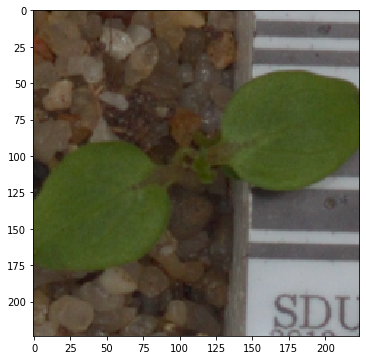

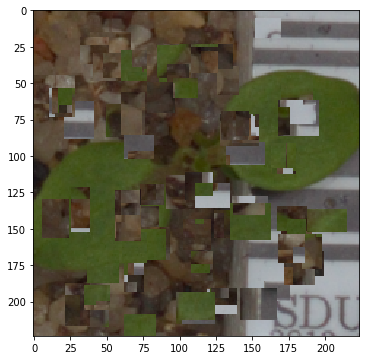

In [4]:
link = "../data/test"
testset = tgenerator(link)

"""Get a clean image, and then get the same image but corrupted
    via patch swapping"""

i = sample(list(range(len(testset))),1)[0]
testset.setmode_none()
image = testset[i]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

testset.setmode_patchswap(p=20, n=30) # Swap 30 pairs of pixel patches, 
                                      # each of size 20x20 on average

image = testset[i]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

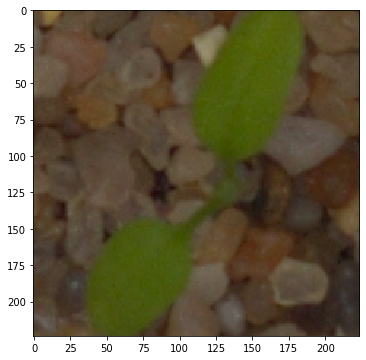

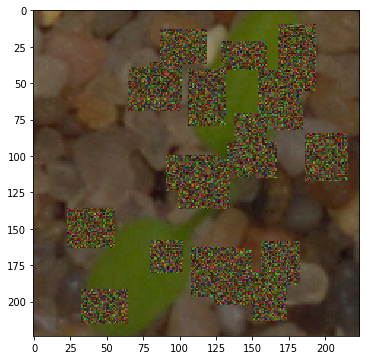

In [5]:
link = "../data/test"
testset = tgenerator(link)

"""Get a clean image, and then get the same image but corrupted
    via noisy patches"""

i = sample(list(range(len(testset))),1)[0]
testset.setmode_none()
image = testset[i]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

testset.setmode_noisypatch(theta=0.1,p=30,n=20) #select three patches and add noise to each of them

image = testset[i]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

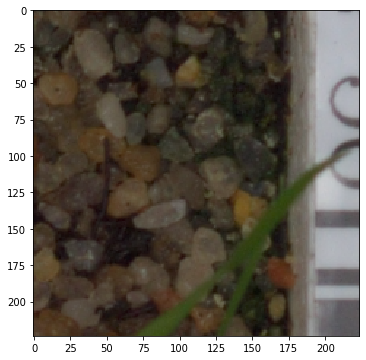

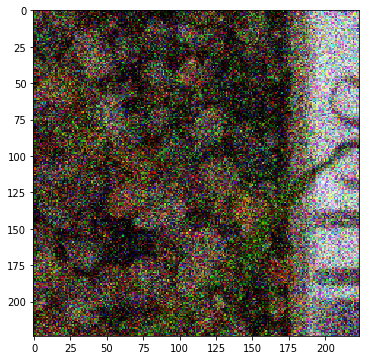

In [7]:
link = "../data/test"
testset = tgenerator(link)

"""Get a clean image, and then get the same image but corrupted
    via uniform noisy pixels"""

i = sample(list(range(len(testset))),1)[0]
testset.setmode_none()
image = testset[i]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

testset.setmode_uniformnoise(theta=0.2) #add noise to each pixel. theta controls extent of noise

image = testset[i]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()